In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
df = pd.read_csv('df_analyst_exported.csv')

# Preprocessing data
print("Data shape:", df.shape)
print("\nMissing values:")
print(df[['appVersion', 'stemmed_text']].isnull().sum())

# Handle missing values
df_clean = df.dropna(subset=['appVersion', 'stemmed_text']).copy()
print(f"\nData after cleaning: {df_clean.shape}")

# Filter hanya data dengan stemmed_text yang tidak kosong
df_clean = df_clean[df_clean['stemmed_text'].str.strip() != '']

Data shape: (41886, 26)

Missing values:
appVersion      7788
stemmed_text    1158
dtype: int64

Data after cleaning: (33184, 26)


In [3]:
# Encode appVersion menjadi numerical
version_mapping = {version: idx for idx, version in enumerate(df_clean['appVersion'].unique())}
df_clean['appVersion_encoded'] = df_clean['appVersion'].map(version_mapping)

print(f"Unique app versions: {len(version_mapping)}")
print("Sample version mapping:", dict(list(version_mapping.items())[:5]))

Unique app versions: 362
Sample version mapping: {'3.251': 0, '3.250': 1, '3.245': 2, '4.01-test': 3, '3.247.1': 4}


In [17]:
def improved_feature_engineering(df_clean):
    # Stopword yang lebih komprehensif
    custom_stopwords = {
        'tidak', 'tokopedia', 'aplikasi', 'banget', 'nya', 'bukan', 'yang', 'dan', 'di', 'ke',
        'dari', 'dengan', 'ini', 'itu', 'saya', 'kamu', 'kami', 'mereka', 'kita', 'ada',
        'adalah', 'atau', 'untuk', 'pada', 'dalam', 'juga', 'bisa', 'akan', 'sudah', 'lagi',
        'sangat', 'sekali', 'saja', 'hanya', 'lebih', 'jadi', 'karena', 'jika', 'kalau',
        'namun', 'tapi', 'oleh', 'sebagai', 'seperti', 'termasuk', 'kepada', 'terhadap',
        'atas', 'dalam', 'luar', 'antara', 'sekitar', 'sini', 'situ', 'sana', 'mana',
        'apa', 'siapa', 'berapa', 'semua', 'seluruh', 'setiap', 'beberapa', 'banyak',
        'sedikit', 'kurang', 'lebih', 'paling', 'terlalu', 'cukup', 'benar', 'betul',
        'sungguh', 'memang', 'mungkin', 'mau', 'harus', 'perlu', 'bisa', 'dapat',
        'tokped', 'app', 'min', 'review', 'ulasan',
        'rating', 'bintang', 'score', 'nilai', 'komentar', 'kritik', 'saran', 'masukan',
        'murah', 'mahal', 'uang', 'duit',
        'rp', 'rupiah', 'masalah', 'kendala', 'gangguan', 'trouble', 'issue', 'problem', 'lambat',
        'tolong', 'bantu', 'help',
        'solusi', 'solusinya', 'penyelesaian', 'komplain', 'keluhan', 'protes',
        'buruknya', 'jeleknya', 'sangat', 'sekali', 'banget', 'cukup', 'kurang', 'lebih',
        'paling', 'amat', 'ya', 'yah', 'yuk', 'wah', 'loh', 'nih', 'sih', 'deh', 'dong', 'mantap', 'bagus', 'batas',
        'bantu', 'keren', 'baik', 'oke', 'terima kasih', 'makasih', 'mudah', 'mantap banget', 'transaksiny', 'aps', 'deh', 'tikopedia', 'agam',
        'sip', 'euy', 
    }
    
    print("Menerapkan TF-IDF dengan parameter optimal...")
    
    # TF-IDF dengan parameter yang lebih ketat
    vectorizer = TfidfVectorizer(
        max_features=500,           # Features yang cukup tapi tidak berlebihan
        min_df=2,                   # Hanya kata yang muncul minimal 2 dokumen
        max_df=0.7,                 # Hapus kata yang muncul di >70% dokumen
        stop_words=list(custom_stopwords),
        ngram_range=(1, 2),         # Include bigrams untuk konteks lebih baik
        sublinear_tf=True,          # Gunakan sublinear TF scaling
        use_idf=True,               # Pastikan IDF digunakan
        smooth_idf=True,            # Smooth IDF weights
        norm='l2'                   # L2 normalization
    )
    
    tfidf_matrix = vectorizer.fit_transform(df_clean['stemmed_text'])
    print(f"TF-IDF matrix shape sebelum selection: {tfidf_matrix.shape}")
    
    # Feature selection berdasarkan variance
    print("Melakukan feature selection berdasarkan variance...")
    
    # Convert to dense matrix untuk variance threshold
    tfidf_dense = tfidf_matrix.toarray()
    
    # Terapkan variance threshold
    selector = VarianceThreshold(threshold=0.01)  # Threshold yang reasonable
    tfidf_selected = selector.fit_transform(tfidf_dense)
    
    print(f"TF-IDF matrix shape setelah selection: {tfidf_selected.shape}")
    print(f"Features reduced: {tfidf_dense.shape[1]} -> {tfidf_selected.shape[1]}")
    
    # Tampilkan beberapa feature penting
    feature_names = vectorizer.get_feature_names_out()
    selected_features = feature_names[selector.get_support()]
    print(f"Sample selected features: {selected_features[:10]}")
    
    return tfidf_selected, vectorizer, selector

print("\n" + "="*60)
print("FEATURE ENGINEERING YANG LEBIH BAIK")
print("="*60)
# Terapkan feature engineering yang lebih baik
tfidf_improved, vectorizer, selector = improved_feature_engineering(df_clean)

# Gabungkan dengan appVersion
app_version_features = df_clean['appVersion_encoded'].values.reshape(-1, 1)
combined_features_improved = np.hstack([tfidf_improved, app_version_features])

print(f"Final combined features shape: {combined_features_improved.shape}")


FEATURE ENGINEERING YANG LEBIH BAIK
Menerapkan TF-IDF dengan parameter optimal...
TF-IDF matrix shape sebelum selection: (33184, 500)
Melakukan feature selection berdasarkan variance...
TF-IDF matrix shape setelah selection: (33184, 2)
Features reduced: 500 -> 2
Sample selected features: ['belanja' 'cepat']
Final combined features shape: (33184, 3)


In [18]:
# =============================================================================
# DIMENSIONALITY REDUCTION SEDERHANA
# =============================================================================

def simple_dimensionality_reduction(features):
    """Dimensionality reduction sederhana tanpa komplikasi"""
    
    print("\nMenerapkan dimensionality reduction sederhana...")
    print(f"Input features shape: {features.shape}")
    
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    n_samples, n_features = features_scaled.shape
    
    # Gunakan PCA dengan komponen yang reasonable
    n_components = min(50, n_features, n_samples - 1)
    
    if n_components < 2:
        print("Too few components, using original features")
        return {
            'features': features_scaled,
            'features_2d': features_scaled[:, :min(2, n_features)],
            'scaler': scaler
        }
    
    try:
        pca = PCA(n_components=n_components)
        features_pca = pca.fit_transform(features_scaled)
        
        # Hitung cumulative variance
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
        
        print(f"PCA dengan {n_components} components")
        print(f"Components untuk 95% variance: {n_components_95}")
        print(f"Variance explained: {cumulative_variance[-1]:.3f}")
        
        # Gunakan features dengan 95% variance atau maksimal 20 components
        final_n_components = min(n_components_95, 20)
        features_final = features_pca[:, :final_n_components]
        
        # Untuk visualisasi, gunakan 2D
        features_2d = features_pca[:, :2]
        
        print(f"Final features untuk clustering: {features_final.shape}")
        
        return {
            'features': features_final,
            'features_2d': features_2d,
            'scaler': scaler,
            'pca': pca
        }
        
    except Exception as e:
        print(f"PCA failed: {e}, using original features")
        return {
            'features': features_scaled,
            'features_2d': features_scaled[:, :min(2, n_features)],
            'scaler': scaler
        }

print("\n" + "="*60)
print("DIMENSIONALITY REDUCTION SEDERHANA")
print("="*60)

reduced_data = simple_dimensionality_reduction(combined_features_improved)
features_for_clustering = reduced_data['features']
features_for_viz = reduced_data['features_2d']

print(f"Features untuk clustering: {features_for_clustering.shape}")
print(f"Features untuk visualisasi: {features_for_viz.shape}")


DIMENSIONALITY REDUCTION SEDERHANA

Menerapkan dimensionality reduction sederhana...
Input features shape: (33184, 3)
PCA dengan 3 components
Components untuk 95% variance: 3
Variance explained: 1.000
Final features untuk clustering: (33184, 3)
Features untuk clustering: (33184, 3)
Features untuk visualisasi: (33184, 2)


In [19]:
# =============================================================================
# CLUSTERING DENGAN PARAMETER FIXED
# =============================================================================

def apply_dbscan_fixed(features):
    """Terapkan DBSCAN dengan parameter fixed yang reasonable"""
    
    # Tentukan parameter berdasarkan dimensi features
    n_features = features.shape[1]
    
    if n_features <= 5:
        eps = 0.5
        min_samples = 3
    elif n_features <= 15:
        eps = 1.2
        min_samples = 10
    else:
        eps = 1.0
        min_samples = 8
    
    print(f"\nMenerapkan DBSCAN dengan parameter fixed:")
    print(f"EPS: {eps}, Min Samples: {min_samples}")
    print(f"Features dimension: {n_features}")
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(features)
    
    return labels, eps, min_samples

print("\n" + "="*60)
print("CLUSTERING DENGAN PARAMETER FIXED")
print("="*60)

# Terapkan clustering
cluster_labels, eps_used, min_samples_used = apply_dbscan_fixed(features_for_clustering)

# Add cluster labels to dataframe
df_clean = df_clean.copy()
df_clean['cluster'] = cluster_labels

# Analisis hasil clustering
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

# Hitung silhouette score
if n_clusters > 1:
    silhouette_avg = silhouette_score(features_for_clustering, cluster_labels)
else:
    silhouette_avg = -1

print(f"\nClustering Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(df_clean)*100:.1f}%)")
print(f"Silhouette Score: {silhouette_avg:.4f}")


CLUSTERING DENGAN PARAMETER FIXED

Menerapkan DBSCAN dengan parameter fixed:
EPS: 0.5, Min Samples: 3
Features dimension: 3

Clustering Results:
Number of clusters: 13
Number of noise points: 30 (0.1%)
Silhouette Score: 0.5017



VISUALISASI HASIL


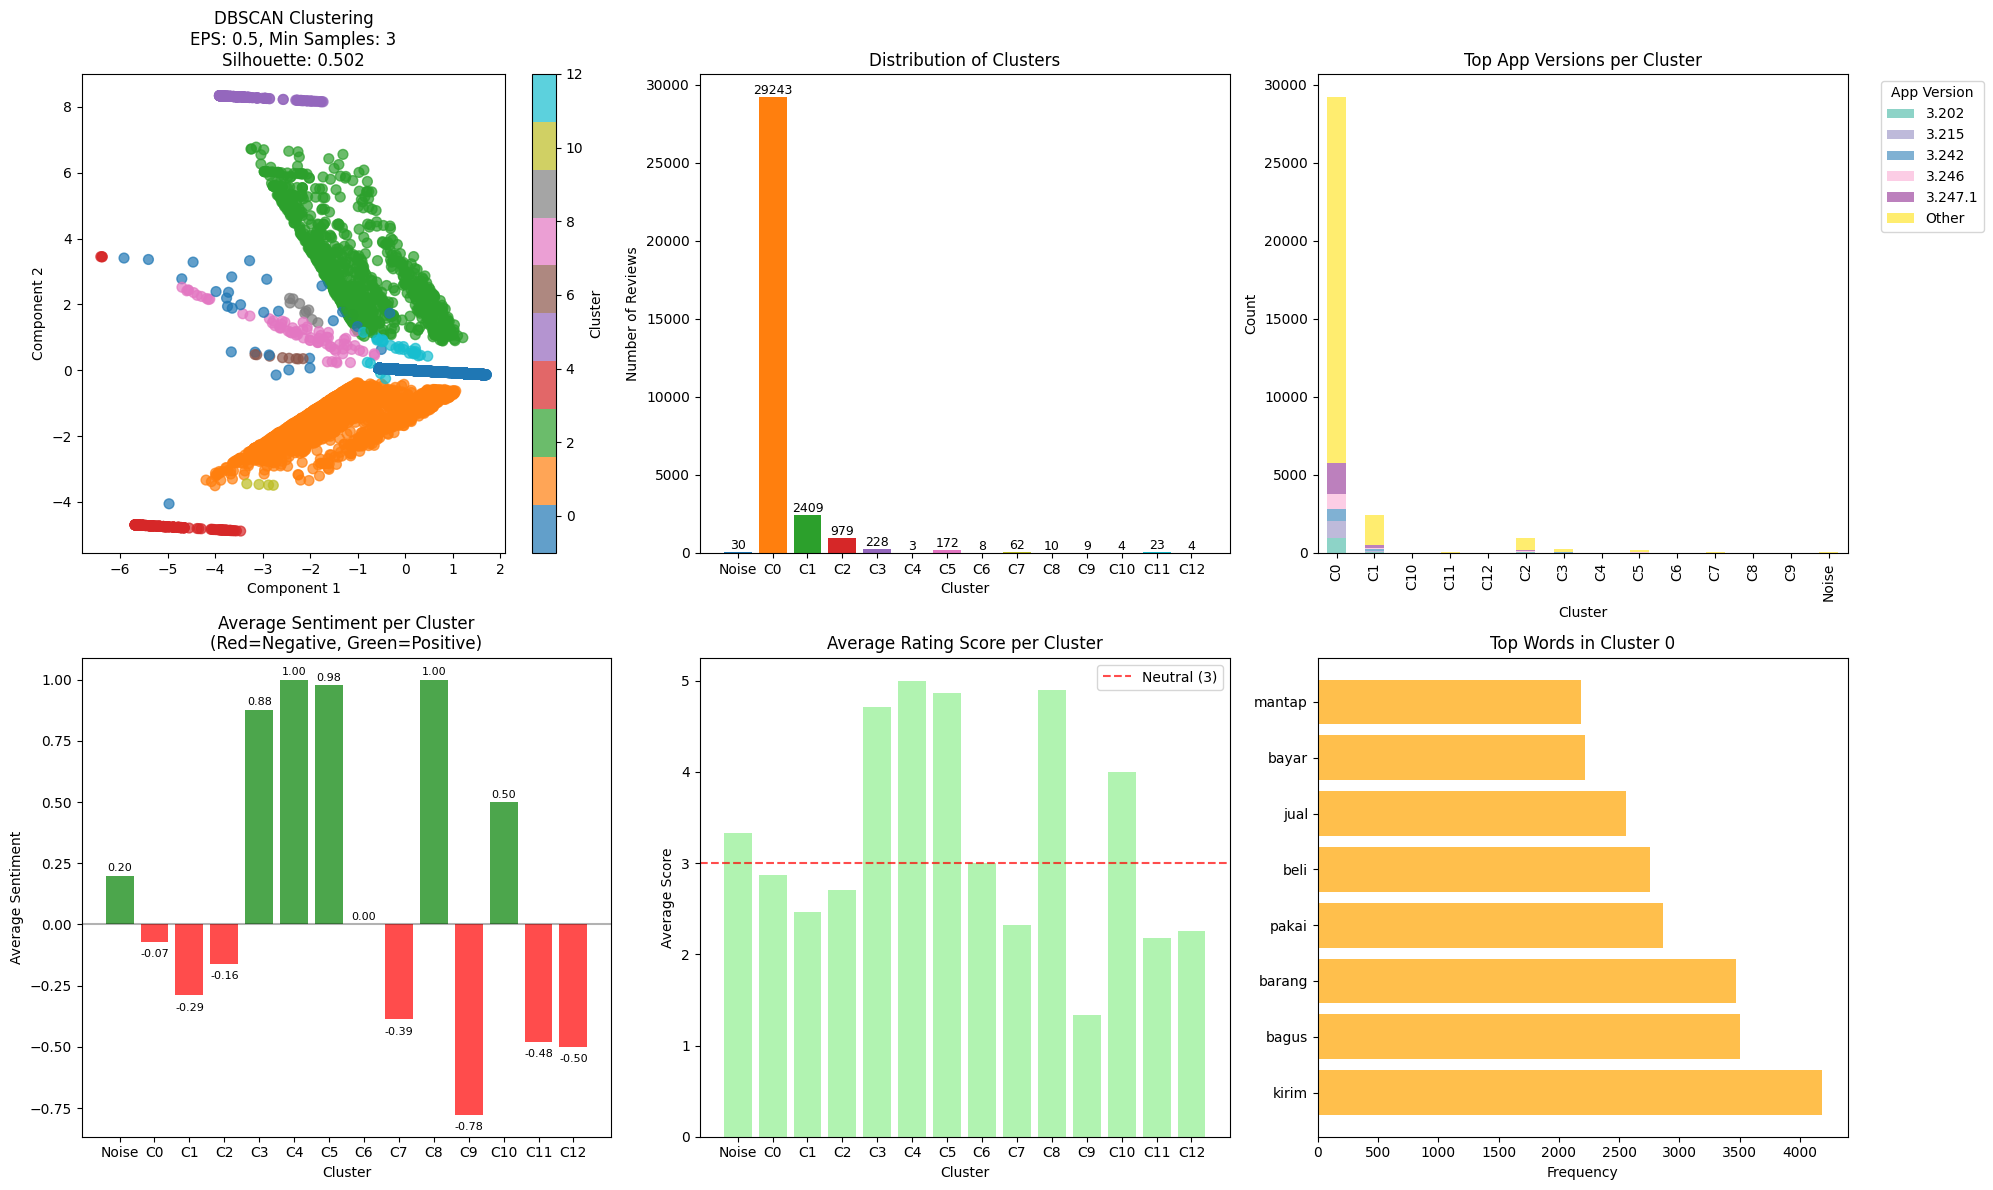

In [20]:
# =============================================================================
# VISUALISASI HASIL
# =============================================================================

print("\n" + "="*60)
print("VISUALISASI HASIL")
print("="*60)

# Buat visualisasi
plt.figure(figsize=(20, 12))

# Plot 1: Cluster visualization
plt.subplot(2, 3, 1)
scatter = plt.scatter(features_for_viz[:, 0], features_for_viz[:, 1], 
                     c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'DBSCAN Clustering\nEPS: {eps_used}, Min Samples: {min_samples_used}\nSilhouette: {silhouette_avg:.3f}')

# Plot 2: Distribution of clusters
plt.subplot(2, 3, 2)
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
colors = plt.cm.tab10(np.arange(len(cluster_counts)))
cluster_names = [f'C{int(x)}' if x != -1 else 'Noise' for x in cluster_counts.index]
bars = plt.bar(cluster_names, cluster_counts.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Clusters')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}', ha='center', va='bottom', fontsize=9)

# Plot 3: App Version distribution per cluster
plt.subplot(2, 3, 3)
# Ambil hanya top 5 app versions untuk visualisasi yang lebih clean
top_versions = df_clean['appVersion'].value_counts().head(5).index
cluster_version_top = pd.crosstab(
    df_clean['cluster'].apply(lambda x: f'C{int(x)}' if x != -1 else 'Noise'), 
    df_clean['appVersion'].apply(lambda x: x if x in top_versions else 'Other')
)
cluster_version_top.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Top App Versions per Cluster')
plt.legend(title='App Version', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Sentiment distribution per cluster
plt.subplot(2, 3, 4)
if 'label' in df_clean.columns:
    sentiment_mapping = {'positive': 1, 'negative': -1}
    df_clean['sentiment_num'] = df_clean['label'].map(sentiment_mapping).fillna(0)
    sentiment_by_cluster = df_clean.groupby('cluster')['sentiment_num'].mean()
    
    cluster_names = [f'C{int(x)}' if x != -1 else 'Noise' for x in sentiment_by_cluster.index]
    colors = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in sentiment_by_cluster.values]
    
    bars = plt.bar(cluster_names, sentiment_by_cluster.values, color=colors, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Cluster')
    plt.ylabel('Average Sentiment')
    plt.title('Average Sentiment per Cluster\n(Red=Negative, Green=Positive)')
    
    for bar, val in zip(bars, sentiment_by_cluster.values):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (0.01 if val >=0 else -0.03),
                f'{val:.2f}', ha='center', va='bottom' if val >=0 else 'top', fontsize=8)
else:
    plt.text(0.5, 0.5, 'No sentiment data', ha='center', va='center')
    plt.axis('off')

# Plot 5: Score distribution per cluster
plt.subplot(2, 3, 5)
if 'score' in df_clean.columns:
    score_by_cluster = df_clean.groupby('cluster')['score'].mean()
    cluster_names = [f'C{int(x)}' if x != -1 else 'Noise' for x in score_by_cluster.index]
    
    plt.bar(cluster_names, score_by_cluster.values, color='lightgreen', alpha=0.7)
    plt.axhline(y=3, color='red', linestyle='--', alpha=0.7, label='Neutral (3)')
    plt.xlabel('Cluster')
    plt.ylabel('Average Score')
    plt.title('Average Rating Score per Cluster')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No score data', ha='center', va='center')
    plt.axis('off')

# Plot 6: Top words for main clusters
plt.subplot(2, 3, 6)
from collections import Counter

# Ambil cluster dengan jumlah anggota terbanyak (kecuali noise)
main_clusters = cluster_counts[cluster_counts.index != -1]
if len(main_clusters) > 0:
    main_cluster = main_clusters.index[0]
    cluster_texts = df_clean[df_clean['cluster'] == main_cluster]['stemmed_text']
    
    # Hitung frekuensi kata
    all_words = ' '.join(cluster_texts).split()
    word_freq = Counter(all_words)
    
    # Filter stopwords tambahan
    additional_stopwords = {'tokopedia', 'aplikasi', 'sangat', 'banget', 'nya', 'yang', 'tidak'}
    filtered_words = {word: freq for word, freq in word_freq.items() 
                     if word not in additional_stopwords and len(word) > 2}
    
    top_words = Counter(filtered_words).most_common(8)
    
    if top_words:
        words, counts = zip(*top_words)
        plt.barh(words, counts, color='orange', alpha=0.7)
        plt.xlabel('Frequency')
        plt.title(f'Top Words in Cluster {main_cluster}')
    else:
        plt.text(0.5, 0.5, 'No significant words', ha='center', va='center')
        plt.axis('off')
else:
    plt.text(0.5, 0.5, 'No main clusters found', ha='center', va='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
# =============================================================================
# ANALISIS DETAIL PER CLUSTER
# =============================================================================

print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS")
print("="*60)

for cluster_id in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_id]
    
    cluster_name = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise Cluster"
    print(f"\n--- {cluster_name} ---")
    print(f"Number of reviews: {len(cluster_data)}")
    
    if cluster_id == -1:
        print("This cluster contains noise/outlier points")
        if 'label' in cluster_data.columns:
            sentiment_dist = cluster_data['label'].value_counts()
            print(f"Sentiment distribution: {sentiment_dist.to_dict()}")
        continue
    
    # App Version analysis
    version_dist = cluster_data['appVersion'].value_counts().head(3)
    print(f"Top App Versions: {version_dist.to_dict()}")
    
    # Sentiment analysis
    if 'label' in cluster_data.columns:
        sentiment_dist = cluster_data['label'].value_counts()
        avg_score = cluster_data['score'].mean() if 'score' in cluster_data.columns else None
        print(f"Sentiment distribution: {sentiment_dist.to_dict()}")
        if avg_score is not None:
            print(f"Average score: {avg_score:.2f}")
    
    # Top words in this cluster
    cluster_texts = cluster_data['stemmed_text']
    all_words = ' '.join(cluster_texts).split()
    word_freq = Counter(all_words)
    
    # Filter stopwords tambahan
    additional_stopwords = {'tokopedia', 'aplikasi', 'sangat', 'banget', 'nya', 'yang', 'tidak'}
    filtered_words = {word: freq for word, freq in word_freq.items() 
                     if word not in additional_stopwords and len(word) > 2}
    
    top_words = Counter(filtered_words).most_common(6)
    print(f"Top words: {[word for word, freq in top_words]}")
    
    # Sample reviews
    print("Sample reviews:")
    sample_reviews = cluster_data['content'].head(2).tolist() if 'content' in cluster_data.columns else []
    for i, review in enumerate(sample_reviews, 1):
        print(f"  {i}. {review[:80]}...")


DETAILED CLUSTER ANALYSIS

--- Noise Cluster ---
Number of reviews: 30
This cluster contains noise/outlier points
Sentiment distribution: {'positive': 18, 'negative': 12}

--- Cluster 0 ---
Number of reviews: 29243
Top App Versions: {'3.247.1': 1992, '3.215': 1094, '3.246': 962}
Sentiment distribution: {'negative': 15649, 'positive': 13594}
Average score: 2.87
Top words: ['kirim', 'bagus', 'barang', 'pakai', 'beli', 'jual']
Sample reviews:
  1. Gk jelas tiba² pembatalan pesanan katanya tidak memenuhi syarat dan ketentuan yg...
  2. . Expedisi nya ga jelas.. Kirim paket aja smpai seminggu ga di kirim2 padahal sa...

--- Cluster 1 ---
Number of reviews: 2409
Top App Versions: {'3.247.1': 190, '3.215': 92, '3.246': 76}
Sentiment distribution: {'negative': 1553, 'positive': 856}
Average score: 2.46
Top words: ['belanja', 'kirim', 'pakai', 'barang', 'ongkos', 'toko']
Sample reviews:
  1. Parah beli barang malah di tuduh manipulasi data padahal data saya sesuai semua ...
  2. tempat belanja

In [22]:
# =============================================================================
# REKOMENDASI BERDASARKAN ANALISIS
# =============================================================================

print("\n" + "="*60)
print("RECOMMENDATIONS & INSIGHTS")
print("="*60)

# 1. Analisis versi aplikasi bermasalah
if 'label' in df_clean.columns:
    version_issues = df_clean[df_clean['label'] == 'negative']['appVersion'].value_counts()
    if len(version_issues) > 0:
        print("\n1. VERSI APLIKASI DENGAN KELUHAN TERBANYAK:")
        for version, count in version_issues.head(3).items():
            version_data = df_clean[df_clean['appVersion'] == version]
            negative_pct = (version_data['label'] == 'negative').mean() * 100
            avg_score = version_data['score'].mean() if 'score' in version_data.columns else None
            score_text = f", avg score: {avg_score:.2f}" if avg_score is not None else ""
            print(f"   📱 {version}: {count} keluhan ({negative_pct:.1f}% negative{score_text})")


RECOMMENDATIONS & INSIGHTS

1. VERSI APLIKASI DENGAN KELUHAN TERBANYAK:
   📱 3.247.1: 1104 keluhan (48.0% negative, avg score: 3.09)
   📱 3.202: 790 keluhan (76.0% negative, avg score: 2.00)
   📱 3.215: 500 keluhan (40.3% negative, avg score: 3.39)


In [23]:
# 2. Analisis cluster dengan masalah
if 'label' in df_clean.columns and n_clusters > 0:
    cluster_negative_ratio = df_clean[df_clean['cluster'] != -1].groupby('cluster').apply(
        lambda x: (x['label'] == 'negative').mean()
    ).sort_values(ascending=False)
    
    if len(cluster_negative_ratio) > 0:
        print("\n2. CLUSTER DENGAN MASALAH TERBANYAK:")
        for cluster_id, negative_ratio in cluster_negative_ratio.head(3).items():
            if cluster_id != -1:
                cluster_size = len(df_clean[df_clean['cluster'] == cluster_id])
                print(f"   🔴 Cluster {cluster_id}: {negative_ratio:.1%} negative ({cluster_size} reviews)")



2. CLUSTER DENGAN MASALAH TERBANYAK:
   🔴 Cluster 9: 88.9% negative (9 reviews)
   🔴 Cluster 12: 75.0% negative (4 reviews)
   🔴 Cluster 11: 73.9% negative (23 reviews)


In [24]:
# 3. Summary performa clustering
print(f"\n3. SUMMARY PERFORMANCE:")
print(f"   ✅ Silhouette Score: {silhouette_avg:.3f}")
print(f"   ✅ Number of clusters: {n_clusters}")
print(f"   ✅ Noise points: {n_noise} ({n_noise/len(df_clean)*100:.1f}%)")
print(f"   ✅ Parameters used: EPS={eps_used}, Min Samples={min_samples_used}")


3. SUMMARY PERFORMANCE:
   ✅ Silhouette Score: 0.502
   ✅ Number of clusters: 13
   ✅ Noise points: 30 (0.1%)
   ✅ Parameters used: EPS=0.5, Min Samples=3


In [31]:
# Impor metrik evaluasi tambahan
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import pandas as pd

print("============================================================")
print("RINGKASAN METRIK GLOBAL")
print("============================================================")

# Inisialisasi variabel (jika cluster gagal)
calinski_avg = float('nan')
davies_avg = float('nan')

# Hitung metrik (memastikan ada lebih dari 1 cluster agar valid)
# Variabel 'n_clusters' dan 'silhouette_avg' sudah dihitung di Cell 6
if n_clusters > 1:
    print(f"Menghitung metrik untuk {n_clusters} cluster...")
    calinski_avg = calinski_harabasz_score(features_for_clustering, cluster_labels)
    davies_avg = davies_bouldin_score(features_for_clustering, cluster_labels)
    
    print(f"Silhouette Score: {silhouette_avg:.6f}")
    print(f"Calinski-Harabasz Score: {calinski_avg:.6f}")
    print(f"Davies-Bouldin Score: {davies_avg:.6f}")
else:
    print("Metrik tidak dapat dihitung (n_clusters <= 1)")

# Buat DataFrame untuk tampilan laporan
metrics_data = {
    "metric": [
        "silhouette", 
        "calinski_harabasz", 
        "davies_bouldin", 
    ],
    "value": [
        silhouette_avg,  # Menggunakan silhouette_avg dari Cell 6
        calinski_avg, 
        davies_avg, 
    ]
}

df_metrics = pd.DataFrame(metrics_data)

print("\nRingkasan metrik global:")
# Menggunakan .to_string() agar outputnya rata seperti di gambar
print(df_metrics.to_string(index=True))

RINGKASAN METRIK GLOBAL
Menghitung metrik untuk 13 cluster...
Silhouette Score: 0.501711
Calinski-Harabasz Score: 3915.675744
Davies-Bouldin Score: 1.014591

Ringkasan metrik global:
              metric        value
0         silhouette     0.501711
1  calinski_harabasz  3915.675744
2     davies_bouldin     1.014591
